In [18]:
%load_ext autoreload
%autoreload 2

import os
import time
import glob
import re
import pandas as pd
from functools import reduce
from klepto.archives import dir_archive

import numpy as np
from tqdm.auto import tqdm
import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
from coffea.analysis_objects import JaggedCandidateArray
from coffea.btag_tools import BTagScaleFactor
from coffea import hist
import pandas as pd
import uproot_methods
import uproot
import awkward
import copy

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from Tools.config_helpers import *
from Tools.helpers import mergeArray, mt, get_scheduler_address

from Tools.objects import Collections
from Tools.cutflow import Cutflow

# This just tells matplotlib not to open any
# interactive windows.
matplotlib.use('Agg')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
def pad_and_flatten(val): 
    try:
        return val.pad(1, clip=True).fillna(0.).flatten()#.reshape(-1, 1)
    except AttributeError:
        return val.flatten()

#os.environ['KERAS_BACKEND'] = 'theano'
#from keras.models import load_model

In [20]:
import sys
sys.setrecursionlimit(10000)
print(sys.getrecursionlimit())

10000


In [21]:
from Tools.WH_objects import *
from Tools.WH_scalefactors import LeptonSF
from Tools.WH_deepAK8 import getWTagSF

In [61]:
#global variables... to avoid making bugs!!!
#processesList = ['mC750_l1', 'WJets', 'TTJets', 'ST', 'ttW', 'WW', 'ZNuNu', 'QCD', 'Data']
processesList = ['mC750_l1','LL','ZNuNu', 'QCD', 'Data']
linesList= ['blinded',
            'trigger', 
            'filter', 
            'skim', 
            'electron veto', 
            'muon veto', 
            'tau veto', 
            'iso track veto', 
            'MET>250', 
            'N_fatjet>1', 
            'min_dphiFatJetMet4', 
            'dphiDiFatJet',
            'N_htag>0',
            'N_wtag>0',
            'minmth>200',
            'on-H',
            'on-W',
            'njet veto', 
           ]
  
year = 2018

In [62]:
class analysisProcessor(processor.ProcessorABC):
    """Processor used for running the analysis"""
    def __init__(self):
        
        ## load b-tag SFs
        #self.btag_sf = BTagScaleFactor(os.path.expandvars("$TWHOME/data/DeepCSV_102XSF_V1.btag.csv.gz", "reshape")

        ## load the NN
        #self.model = load_model('../ML/data/training.h5')
        #self.stds  = pd.read_json('../ML/data/stds.json').squeeze()
        #self.means = pd.read_json('../ML/data/means.json').squeeze()
        
        # we can use a large number of bins and rebin later
        dataset_axis        = hist.Cat("dataset",   "Primary dataset")
        pt_axis             = hist.Bin("pt",        r"$p_{T}$ (GeV)", 1000, 0, 1000)
        p_axis              = hist.Bin("p",         r"$p$ (GeV)", 1000, 0, 2500)
        ht_axis             = hist.Bin("ht",        r"$H_{T}$ (GeV)", 500, 0, 5000)
        mass_axis           = hist.Bin("mass",      r"M (GeV)", 1000, 0, 2000)
        eta_axis            = hist.Bin("eta",       r"$\eta$", 60, -5.5, 5.5)
        delta_axis          = hist.Bin("delta",     r"$\delta$", 100,0,10 )
        multiplicity_axis   = hist.Bin("multiplicity",         r"N", 20, -0.5, 19.5)
        norm_axis           = hist.Bin("norm",         r"N", 25, 0, 1)

        self._accumulator = processor.dict_accumulator({
            #"MET_pt_baseline" :          hist.Hist("Counts", dataset_axis, pt_axis),
            #"HT_baseline" :              hist.Hist("Counts", dataset_axis, ht_axis),
            #"mtb_min_baseline" :         hist.Hist("Counts", dataset_axis, mass_axis),
            #"MET_pt" :          hist.Hist("Counts", dataset_axis, pt_axis),
            #"HT" :              hist.Hist("Counts", dataset_axis, ht_axis),
            #"mtb_min" :         hist.Hist("Counts", dataset_axis, mass_axis),
            #"MET_pt_CR" :       hist.Hist("Counts", dataset_axis, pt_axis),
            #"HT_CR" :           hist.Hist("Counts", dataset_axis, ht_axis),
            #"mtb_min_CR" :      hist.Hist("Counts", dataset_axis, mass_axis),
            #"lead_AK8_pt" :     hist.Hist("Counts", dataset_axis, pt_axis),
            #"W_pt" :            hist.Hist("Counts", dataset_axis, pt_axis),
            #"H_pt" :            hist.Hist("Counts", dataset_axis, pt_axis),
            #"W_eta" :           hist.Hist("Counts", dataset_axis, eta_axis),
            #"H_eta" :           hist.Hist("Counts", dataset_axis, eta_axis),
            
            "met_CR":           hist.Hist("Counts", dataset_axis, pt_axis),
            "met_SR":           hist.Hist("Counts", dataset_axis, pt_axis),
            "met_VR_CR":        hist.Hist("Counts", dataset_axis, pt_axis),
            "met_VR_SR":        hist.Hist("Counts", dataset_axis, pt_axis),
            
            "met_Higgs_CR":     hist.Hist("Counts", dataset_axis, pt_axis),
            "met_W_CR":         hist.Hist("Counts", dataset_axis, pt_axis),
            "met_Higgs_W_CR":   hist.Hist("Counts", dataset_axis, pt_axis),
            
            "ht_CR":            hist.Hist("Counts", dataset_axis, ht_axis),
            "ht_Higgs_CR":      hist.Hist("Counts", dataset_axis, ht_axis),
            "ht_W_CR":          hist.Hist("Counts", dataset_axis, ht_axis),
            "ht_Higgs_W_CR":    hist.Hist("Counts", dataset_axis, ht_axis),
            
            "N_AK8_CR" :        hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "W_pt_CR" :         hist.Hist("Counts", dataset_axis, pt_axis),
            "H_pt_CR" :         hist.Hist("Counts", dataset_axis, pt_axis),
            "W_eta_CR" :        hist.Hist("Counts", dataset_axis, eta_axis),
            "H_eta_CR" :        hist.Hist("Counts", dataset_axis, eta_axis),
            
            "N_AK8_Higgs_CR" :  hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "W_pt_Higgs_CR" :   hist.Hist("Counts", dataset_axis, pt_axis),
            "H_pt_Higgs_CR" :   hist.Hist("Counts", dataset_axis, pt_axis),
            "W_eta_Higgs_CR" :  hist.Hist("Counts", dataset_axis, eta_axis),
            "H_eta_Higgs_CR" :  hist.Hist("Counts", dataset_axis, eta_axis),
            
            "N_AK8_W_CR" :      hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "W_pt_W_CR" :       hist.Hist("Counts", dataset_axis, pt_axis),
            "H_pt_W_CR" :       hist.Hist("Counts", dataset_axis, pt_axis),
            "W_eta_W_CR" :      hist.Hist("Counts", dataset_axis, eta_axis),
            "H_eta_W_CR" :      hist.Hist("Counts", dataset_axis, eta_axis),
            
            "N_AK8_Higgs_W_CR" :hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "W_pt_Higgs_W_CR" : hist.Hist("Counts", dataset_axis, pt_axis),
            "H_pt_Higgs_W_CR" : hist.Hist("Counts", dataset_axis, pt_axis),
            "W_eta_Higgs_W_CR" :hist.Hist("Counts", dataset_axis, eta_axis),
            "H_eta_Higgs_W_CR" :hist.Hist("Counts", dataset_axis, eta_axis),
            
            "lead_AK8_pt" :     hist.Hist("Counts", dataset_axis, pt_axis),
            "sublead_AK8_pt" :  hist.Hist("Counts", dataset_axis, pt_axis),
            "lead_AK8_eta" :    hist.Hist("Counts", dataset_axis, eta_axis),
            "sublead_AK8_eta" : hist.Hist("Counts", dataset_axis, eta_axis),
            "lead_AK8_mass" :   hist.Hist("Counts", dataset_axis, mass_axis),
            "sublead_AK8_mass" : hist.Hist("Counts", dataset_axis, mass_axis),
            "N_W_CR" :          hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_H_CR" :          hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_AK4_CR" :        hist.Hist("Counts", dataset_axis, multiplicity_axis),


            #"N_b" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            #"N_AK4" :           hist.Hist("Counts", dataset_axis, multiplicity_axis),
            #"N_AK8" :           hist.Hist("Counts", dataset_axis, multiplicity_axis),
            #"N_H" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            #"N_W" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            
            #"WH_deltaPhi":      hist.Hist("Counts", dataset_axis, delta_axis),
            #"WH_deltaR":        hist.Hist("Counts", dataset_axis, delta_axis),
            #"bb_deltaPhi":      hist.Hist("Counts", dataset_axis, delta_axis),
            #"bb_deltaR":        hist.Hist("Counts", dataset_axis, delta_axis),
            #"min_dphiJetMet4":  hist.Hist("Counts", dataset_axis, delta_axis),
            #"dphiDiJet":        hist.Hist("Counts", dataset_axis, delta_axis),
            #"dphiDiFatJet":     hist.Hist("Counts", dataset_axis, delta_axis),
            
            'mC750_l1':         processor.defaultdict_accumulator(int),
            'WJets':            processor.defaultdict_accumulator(int),
            'WJetsOld':         processor.defaultdict_accumulator(int),
            'WJetsNew':         processor.defaultdict_accumulator(int),
            'QCD':              processor.defaultdict_accumulator(int),
            'TTJets':           processor.defaultdict_accumulator(int),
            'ttbarOld':         processor.defaultdict_accumulator(int),
            'ttbarNew':         processor.defaultdict_accumulator(int),
            'ZNuNu':            processor.defaultdict_accumulator(int),
            'ST':               processor.defaultdict_accumulator(int),
            'ST_tW':            processor.defaultdict_accumulator(int),
            'ST_tChannel':      processor.defaultdict_accumulator(int),
            'ST_sChannel':      processor.defaultdict_accumulator(int),
            'ttW':              processor.defaultdict_accumulator(int),
            'ttZ':              processor.defaultdict_accumulator(int),
            'WW':               processor.defaultdict_accumulator(int),
            'WZ/ZZ':            processor.defaultdict_accumulator(int),
            'LL':               processor.defaultdict_accumulator(int),
            'Data':             processor.defaultdict_accumulator(int),
            'totalEvents':      processor.defaultdict_accumulator(int),
            'test1':            processor.defaultdict_accumulator(float),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        """
        Processing function. This is where the actual analysis happens.
        """
        output = self.accumulator.identity()
        dataset = df["dataset"]
        cfg = loadConfig()
        
        ## MET -> can switch to puppi MET
        met_pt  = df["MET_pt"]
        met_phi = df["MET_phi"]
        
        ## Load Objects
        muon     = getMuons(df, WP='veto')
        electron = getElectrons(df, WP='veto')
        tau      = getTaus(df)
        isotrack = getIsoTracks(df)
        fatjet   = getFatJets(df)
        jet      = getJets(df)
        
        triggers = getTriggers(df, year=year, dataset=dataset) 
        filters  = getFilters(df, year=year, dataset=dataset)
        
        sf = LeptonSF(year=year)
        leptonSF = sf.get(electron, muon)
        
        ## Clean Objects
        skimjet   = jet[(jet.pt>30) & (jet.jetId>1) & (abs(jet.eta)<2.4)]
        jet       = jet[~jet.match(muon, deltaRCut=0.4)] # remove jets that overlap with muons
        jet       = jet[~jet.match(electron, deltaRCut=0.4)] # remove jets that overlap with electrons
        jet       = jet[jet.pt.argsort(ascending=False)] # sort the jets
        extrajet  = jet[~jet.match(fatjet, deltaRCut=0.8)] # remove AK4 jets that overlap with AK8 jets
        btag      = getBTags(jet, year=year)
        
        ## Calculating Variables
        
        ## FatJet Variables
        leadingFatJets = fatjet[:,:2]
        
        leadFatJet = fatjet[:,:1]
        subleadFatJet = fatjet[:,1:2]
        
        difatjet = leadingFatJets.choose(2)
        dphiDiFatJet = np.arccos(np.cos(difatjet.i0.phi-difatjet.i1.phi))
        
        min_dphiFatJetMet4 = np.arccos(np.cos(fatjet[:,:4].phi-met_phi)).min()

        ## H-tagged Variables
        htag = fatjet[((fatjet.pt > 200) & (fatjet.deepTagMD_HbbvsQCD > 0.8365))]
        lead_htag = htag[htag.pt.argmax()]
        
        ## W-tagged Variables
        # deepAK8 working points: https://twiki.cern.ch/twiki/bin/viewauth/CMS/DeepAK8Tagging2018WPsSFs
        wtag = fatjet[((fatjet.pt > 200) & (fatjet.deepTagMD_HbbvsQCD < 0.8365) & (fatjet.deepTag_WvsQCD > 0.918))]
        wtag_vloose = fatjet[((fatjet.pt > 200) & (fatjet.deepTagMD_HbbvsQCD < 0.8365) & (fatjet.deepTag_WvsQCD > 0.458))]
        wtag_loose = fatjet[((fatjet.pt > 200) & (fatjet.deepTagMD_HbbvsQCD < 0.8365) & (fatjet.deepTag_WvsQCD > 0.762))]
        wtag_hard = fatjet[((fatjet.pt > 300) & (fatjet.deepTagMD_HbbvsQCD < 0.8365) & (fatjet.deepTag_WvsQCD > 0.918))]
        
        if dataset.lower().count('data')==0:
            GenW = getGenW(df)
            wtag_SF = getWTagSF(wtag, GenW, year=year)
        
        lead_wtag = wtag[wtag.pt.argmax()]
        
        ## W, H tagged variables
        wh = lead_htag.cross(lead_wtag)
        wh_deltaPhi = np.arccos(wh.i0.phi - wh.i1.phi)
        wh_deltaR = wh.i0.p4.delta_r(wh.i1.p4)
        
        ## b-tagged variables
        high_score_btag = jet[jet.btagDeepB.argsort(ascending=False)][:,:2]
        
        leading_jet    = jet[jet.pt.argmax()]
        leading_b      = btag[btag.pt.argmax()]
        
        bb = high_score_btag.choose(2)
        bb_deltaPhi = np.arccos(np.cos(bb.i0.phi-bb.i1.phi))
        bb_deltaR = bb.i0.p4.delta_r(bb.i1.p4)
        
        ## mt variables
        mtb = mt(btag.pt, btag.phi, met_pt, met_phi)
        min_mtb = mtb.min()
        mth = mt(htag.pt, htag.phi, met_pt, met_phi)
        mtw = mt(wtag.pt, wtag.phi, met_pt, met_phi)

        ## other variables
        ht = fatjet.pt.sum()
        
        min_dphiJetMet4 = np.arccos(np.cos(jet[:,:4].phi-met_phi)).min()
        
        leadingJets = jet[:,:2]
        dijet = leadingJets.choose(2)
        dphiDiJet = np.arccos(np.cos(dijet.i0.phi-dijet.i1.phi))
        
        diAK4AK8 = fatjet.cross(extrajet)
        deltaRAK4AK8 = diAK4AK8.i0.p4.delta_r(diAK4AK8.i1.p4)
        
        ## variables for selections       
        wtag_sel = ( wtag.counts>0 & (abs(wtag.msoftdrop-80)<30).any())
        htag_sel = ( htag.counts>0 & (abs(htag.msoftdrop-125)<25).any())
        #stitchVar = 1 if dataset=='Data' else df["stitch"]
        blind_protection = True if dataset.lower().count('data')==0 else ((electron.counts+muon.counts)>0 | (htag.msoftdrop>180).all())

        ## define selections (maybe move to a different file at some point)
        
        output['totalEvents']['all'] += len(df['weight'])
        
        # Cutflow
        processes = processesList
        #weight = np.ones(len(df['weight'])) if dataset=='Data' else df['weight']
        #lumi = 1 if dataset=='Data' else 60.*LeptonSF
        #fullweight = weight * lumi
        weight      = np.ones(len(df['weight'])) if dataset=='Data' else df['weight']*df['puWeight']*leptonSF*wtag_SF
        lumis       = {2016: 36., 2017: 41.5, 2018: 60.}
        cfg['lumi'] = 1 if dataset=='Data' else lumis[year]
        fullweight  = weight*cfg['lumi']
        
        cutflow = Cutflow(output, df, cfg, processes, weight=weight)
        
        cutflow.addRow( 'blinded',  (blind_protection) )
        cutflow.addRow( 'trigger',  (triggers) )
        cutflow.addRow( 'filter',   (filters) )
        cutflow.addRow( 'skim',     ((met_pt>200) & (skimjet.counts>1)) )
        cutflow.addRow( 'electron veto',   (electron.counts==0) )
        cutflow.addRow( 'muon veto',   (muon.counts==0) )
        cutflow.addRow( 'tau veto',    (tau.counts==0) )
        cutflow.addRow( 'iso track veto',   (isotrack.counts==0) )
        cutflow.addRow( 'MET>250',     (met_pt>250) )
                
        baseline = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'N_fatjet>1',      (fatjet.counts>1) )
        cutflow.addRow( 'min_dphiFatJetMet4', (min_dphiFatJetMet4>0.5))
        cutflow.addRow( 'dphiDiFatJet', (dphiDiFatJet<2.5).all() ) # by using .all() I do not implicitely cut on the number of fat jets
        
        vetoQCD = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'N_htag>0',     (htag.counts>0))
        cutflow.addRow( 'N_wtag>0',     (wtag.counts>0))
        
        twotag_selection = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'minmth>200',   (mth.min()>200) )
        cutflow.addRow( 'on-H',     (abs(htag.msoftdrop-125)<25).any())
        cutflow.addRow( 'on-W',     (abs(wtag.msoftdrop-80)<30).any())
        cutflow.addRow( 'njet veto',     (extrajet.counts<2))
        
        SR_selection = copy.deepcopy(cutflow.selection)
        
        # CR selection
        CR_selection  = triggers & filters & ((electron.counts+muon.counts)==1)  & (met_pt>250) & (fatjet.counts>1)
        CR_selection &= (min_dphiFatJetMet4>0.5) & (dphiDiFatJet<2.5).all() & (htag.counts>0) & (mth.min()>200)
        CR_selection &= (abs(htag.msoftdrop-125)<25).any() & (extrajet.counts<2)
        
        '''cutflow.addRow( 'filters',   (filters) )
        cutflow.addRow( 'triggers',   (triggers) )        
        cutflow.addRow( 'skim',   ((met_pt>200) & (skimjet.counts>1)) )
        cutflow.addRow( 'Exactly 1 e or mu',   ((electron.counts+muon.counts)==1) )
        cutflow.addRow( 'MET>250',     (met_pt>250) )
        
        baseline = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'N_fatjet>1',      (fatjet.counts>1) )
        cutflow.addRow( 'min_dphiFatJetMet4', (min_dphiFatJetMet4>0.5))
        cutflow.addRow( 'dphiDiFatJet', (dphiDiFatJet<2.5).all() ) # by using .all() I do not implicitely cut on the number of fat jets
        cutflow.addRow( 'minmth>200',   (mth.min()>200) )
        cutflow.addRow( 'njet veto',     (extrajet.counts<2))

        vetoQCD = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'N_htag>0',     (htag_sel))#, cumulative=False)
        
        CR_selection = cutflow.selection
        
        # SR Selection
        SR_selection  = blind_protection & triggers & filters & ((electron.counts+muon.counts+tau.counts+isotrack.counts)==0)  & (met_pt>250) & (fatjet.counts>1)
        SR_selection &= (min_dphiFatJetMet4>0.5) & (dphiDiFatJet<2.5).all() & (htag_sel) & (wtag_sel) & (mth.min()>200)& (extrajet.counts<2)
        '''
        
        # VR_CR selection
        VR_CR_selection  = triggers & filters & ((electron.counts+muon.counts)==1)  & (met_pt>250) & (fatjet.counts>1)
        VR_CR_selection &= (min_dphiFatJetMet4>0.5) & (dphiDiFatJet<2.5).all() & (htag.counts>0) #& (mth.min()>200)
        VR_CR_selection &= (htag.msoftdrop>180).all()
        #VR_CR_selection &= (abs(htag.msoftdrop-125)>30).all()
        
        # VR_SR selection
        VR_SR_selection  = triggers & filters & (electron.counts==0) & (muon.counts==0) & (tau.counts==0) & (isotrack.counts==0) & (met_pt>250) & (fatjet.counts>1)
        VR_SR_selection &= (min_dphiFatJetMet4>0.5) & (dphiDiFatJet<2.5).all() & (htag.counts>0) #& (mth.min()>200)
        VR_SR_selection &= (htag.msoftdrop>180).all()
        #VR_SR_selection &= (abs(htag.msoftdrop-125)>30).all()

        ### And fill the histograms
        output['met_CR'].fill(dataset=dataset, pt=met_pt[CR_selection].flatten(), weight=fullweight[CR_selection])
        output['met_SR'].fill(dataset=dataset, pt=met_pt[SR_selection].flatten(), weight=fullweight[SR_selection])
        output['met_VR_CR'].fill(dataset=dataset, pt=met_pt[VR_CR_selection].flatten(), weight=fullweight[VR_CR_selection])
        output['met_VR_SR'].fill(dataset=dataset, pt=met_pt[VR_SR_selection].flatten(), weight=fullweight[VR_SR_selection])
        
        output['met_W_CR'].fill(dataset=dataset, pt=met_pt[vetoQCD & wtag_sel].flatten(), weight=fullweight[vetoQCD & wtag_sel])
        output['met_Higgs_CR'].fill(dataset=dataset, pt=met_pt[vetoQCD & htag_sel].flatten(), weight=fullweight[vetoQCD & htag_sel])
        output['met_Higgs_W_CR'].fill(dataset=dataset, pt=met_pt[CR_selection].flatten(), weight=fullweight[CR_selection])

        output['ht_CR'].fill(dataset=dataset, ht=ht[vetoQCD].flatten(), weight=fullweight[vetoQCD])
        output['ht_W_CR'].fill(dataset=dataset, ht=ht[vetoQCD & wtag_sel].flatten(), weight=fullweight[vetoQCD & wtag_sel])
        output['ht_Higgs_CR'].fill(dataset=dataset, ht=ht[vetoQCD & htag_sel].flatten(), weight=fullweight[vetoQCD & htag_sel])
        output['ht_Higgs_W_CR'].fill(dataset=dataset, ht=ht[CR_selection].flatten(), weight=fullweight[CR_selection])
        
        output['N_AK8_CR'].fill(dataset=dataset, multiplicity=fatjet[vetoQCD].counts, weight=fullweight[vetoQCD])
        #output['W_pt_CR'].fill(dataset=dataset, pt=lead_wtag[vetoQCD].pt.flatten(), weight=fullweight[vetoQCD])
        #output['H_pt_CR'].fill(dataset=dataset, pt=lead_htag[vetoQCD].pt.flatten(), weight=fullweight[vetoQCD])
        #output['W_eta_CR'].fill(dataset=dataset, eta=lead_wtag[vetoQCD].eta.flatten(), weight=fullweight[vetoQCD])
        #output['H_eta_CR'].fill(dataset=dataset, eta=lead_htag[vetoQCD].eta.flatten(), weight=fullweight[vetoQCD])

        output['lead_AK8_pt'].fill(dataset=dataset, pt=leadFatJet[vetoQCD].pt.flatten(), weight=fullweight[vetoQCD])
        output['sublead_AK8_pt'].fill(dataset=dataset, pt=subleadFatJet[vetoQCD].pt.flatten(), weight=fullweight[vetoQCD])
        output['lead_AK8_eta'].fill(dataset=dataset, eta=leadFatJet[vetoQCD].eta.flatten(), weight=fullweight[vetoQCD])
        output['sublead_AK8_eta'].fill(dataset=dataset, eta=subleadFatJet[vetoQCD].eta.flatten(), weight=fullweight[vetoQCD])
        output['lead_AK8_mass'].fill(dataset=dataset, mass=leadFatJet[vetoQCD].msoftdrop.flatten(), weight=fullweight[vetoQCD])
        output['sublead_AK8_mass'].fill(dataset=dataset, mass=subleadFatJet[vetoQCD].msoftdrop.flatten(), weight=fullweight[vetoQCD])
        output['N_W_CR'].fill(dataset=dataset, multiplicity=wtag[vetoQCD].counts, weight=fullweight[vetoQCD])
        output['N_H_CR'].fill(dataset=dataset, multiplicity=htag[vetoQCD].counts, weight=fullweight[vetoQCD])
        output['N_AK4_CR'].fill(dataset=dataset, multiplicity=jet[vetoQCD].counts, weight=fullweight[vetoQCD])
                
        output['N_AK8_W_CR'].fill(dataset=dataset, multiplicity=fatjet[vetoQCD & wtag_sel].counts, weight=fullweight[vetoQCD & wtag_sel])
        output['W_pt_W_CR'].fill(dataset=dataset, pt=lead_wtag[vetoQCD & wtag_sel].pt.flatten(), weight=fullweight[vetoQCD & wtag_sel])
        #output['H_pt_W_CR'].fill(dataset=dataset, pt=lead_htag[vetoQCD & wtag_sel].pt.flatten(), weight=fullweight[vetoQCD & wtag_sel])
        output['W_eta_W_CR'].fill(dataset=dataset, eta=lead_wtag[vetoQCD & wtag_sel].eta.flatten(), weight=fullweight[vetoQCD & wtag_sel])
        #output['H_eta_W_CR'].fill(dataset=dataset, eta=lead_htag[vetoQCD & wtag_sel].eta.flatten(), weight=fullweight[vetoQCD & wtag_sel])

        output['N_AK8_Higgs_CR'].fill(dataset=dataset, multiplicity=fatjet[vetoQCD & htag_sel].counts, weight=fullweight[vetoQCD & htag_sel])
        #output['W_pt_Higgs_CR'].fill(dataset=dataset, pt=lead_wtag[vetoQCD & htag_sel].pt.flatten(), weight=fullweight[vetoQCD & htag_sel])
        output['H_pt_Higgs_CR'].fill(dataset=dataset, pt=lead_htag[vetoQCD & htag_sel].pt.flatten(), weight=fullweight[vetoQCD & htag_sel])
        #output['W_eta_Higgs_CR'].fill(dataset=dataset, eta=lead_wtag[vetoQCD & htag_sel].eta.flatten(), weight=fullweight[vetoQCD & htag_sel])
        output['H_eta_Higgs_CR'].fill(dataset=dataset, eta=lead_htag[vetoQCD & htag_sel].eta.flatten(), weight=fullweight[vetoQCD & htag_sel])

        #output['N_AK8_Higgs_W_CR'].fill(dataset=dataset, multiplicity=fatjet[CR_selection].counts, weight=fullweight[CR_selection])
        #output['W_pt_Higgs_W_CR'].fill(dataset=dataset, pt=lead_wtag[CR_selection].pt.flatten(), weight=fullweight[CR_selection])
        #output['H_pt_Higgs_W_CR'].fill(dataset=dataset, pt=lead_htag[CR_selection].pt.flatten(), weight=fullweight[CR_selection])
        #output['W_eta_Higgs_W_CR'].fill(dataset=dataset, eta=lead_wtag[CR_selection].eta.flatten(), weight=fullweight[CR_selection])
        #output['H_eta_Higgs_W_CR'].fill(dataset=dataset, eta=lead_htag[CR_selection].eta.flatten(), weight=fullweight[CR_selection])

        return output

    def postprocess(self, accumulator):
        return accumulator

In [63]:
runLocal = True


if not runLocal:
    # Get the scheduler from the dask_cluster notebook
    from dask.distributed import Client, progress

    c = Client('tcp://169.228.130.5:27879')

    ## for dask
    exe_args = {
        'client': c,
        #'savemetrics': True,
    }
    exe = processor.dask_executor
    
else:
    ## for local
    exe_args = {
        'workers': 4,
        'function_args': {'flatten': False}
    }
    exe = processor.futures_executor

if not runLocal:
    print(c)

In [64]:
overwrite = True
small = False

tag = '0p1p27'


from Tools.WH_samples import * #fileset_2016, fileset_2016_small

if year == 2016:
    fileset_year = fileset_2016
    fileset_year_small = fileset_2016_small
elif year == 2017:
    fileset_year = fileset_2017
    fileset_year_small = fileset_2017_small
elif year == 2018:
    fileset_year = fileset_2018
    fileset_year_small = fileset_2018_small


fileset_WH_merge   = {   #'1000_1_scan': glob.glob('/hadoop/cms/store/user/dspitzba/WH_hadronic/v0.2.4/Autumn18_TChiWH_1000_1.root'),
                'mC750_l1': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/WH_had_750_1_nanoAOD/*.root'),
                'LL': fileset_year['WJets'] + fileset_year['TTJets'] + fileset_year['ST'] + fileset_year['WW'] + fileset_year['TTW'],
                'QCD': fileset_year['QCD'],
                'ZNuNu': fileset_year['ZNuNu'] + fileset_year['TTZ'] + fileset_year['VV'],
                'Data': fileset_year['MET'],
                }

# load the config and the cache
cfg = loadConfig()

cacheName = 'WH_%s_small'%year if small else 'WH_%s'%year
print(cacheName)

# histograms
histograms = []
histograms += ['N_AK4']

# initialize cache
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)
if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    # Run the processor
    if small:
        fileset = {
                    'mC750_l1': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/WH_had_750_1_nanoAOD/*.root'),
                    #'750_1_scan': glob.glob('/hadoop/cms/store/user/dspitzba/WHhadronic/signal/GenModel_TChiWH_750_1.root'),
                    #'1000_1_scan': glob.glob('/hadoop/cms/store/user/dspitzba/WH_hadronic/v0.2.4/Autumn18_TChiWH_1000_1.root'),
                    'LL': fileset_WH_merge['LL'][:2],
                    'Data': fileset_WH_merge['Data'][:2]
        }
        exe_args['workers'] = 4
    else:
        fileset = fileset_WH_merge
        exe_args['workers'] = 16
    
        
    output = processor.run_uproot_job(fileset,
                                      treename='Events',
                                      processor_instance=analysisProcessor(),
                                      executor=exe,
                                      executor_args=exe_args,
                                      #chunksize=250000,
                                      chunksize=100000,
                                     )
    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()

WH_2018


HBox(children=(HTML(value='Preprocessing'), FloatProgress(value=0.0, max=766.0), HTML(value='')))

HBox(children=(HTML(value='Processing'), FloatProgress(value=0.0, max=1008.0), HTML(value='')))

/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/awkward/array/j

In [65]:
# Cutflow
from Tools.helpers import getCutFlowTable

processes = processesList
lines     = ['entry']
lines    += linesList
df        = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, signal='mC750_l1')
df

,mC750_l1,LL,ZNuNu,QCD,Data,S/B
entry,0.0 +/- 0.0,11200000.0 +/- 10000.0,1442000.0 +/- 1000.0,13250000.0 +/- 60000.0,14040000.0 +/- 0.0,0.0
blinded,0.0 +/- 0.0,11200000.0 +/- 10000.0,1442000.0 +/- 1000.0,13250000.0 +/- 60000.0,931500.0 +/- 1000.0,0.0
trigger,0.0 +/- 0.0,11200000.0 +/- 10000.0,1442000.0 +/- 1000.0,13250000.0 +/- 60000.0,789500.0 +/- 900.0,0.0
filter,0.0 +/- 0.0,11170000.0 +/- 10000.0,1440000.0 +/- 1000.0,12700000.0 +/- 60000.0,785600.0 +/- 900.0,0.0
skim,0.0 +/- 0.0,2317000.0 +/- 3000.0,865500.0 +/- 500.0,1033000.0 +/- 7000.0,88460.0 +/- 300.0,0.0
electron veto,0.0 +/- 0.0,1754000.0 +/- 3000.0,860000.0 +/- 500.0,1028000.0 +/- 7000.0,33170.0 +/- 180.0,0.0
muon veto,0.0 +/- 0.0,1111000.0 +/- 2000.0,855000.0 +/- 500.0,955400.0 +/- 5500.0,0.0 +/- 0.0,0.0
tau veto,0.0 +/- 0.0,891200.0 +/- 2000.0,844900.0 +/- 500.0,942500.0 +/- 5400.0,0.0 +/- 0.0,0.0
iso track veto,0.0 +/- 0.0,821500.0 +/- 1900.0,822000.0 +/- 500.0,912400.0 +/- 5300.0,0.0 +/- 0.0,0.0
MET>250,0.0 +/- 0.0,315600.0 +/- 1200.0,384900.0 +/- 300.0,238900.0 +/- 1800.0,0.0 +/- 0.0,0.0


In [66]:
# Efficiencies
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=3, absolute=False)
df

,mC750_l1,LL,ZNuNu,QCD,Data
entry,1.0,1.000,1.000,1.000,1.000
blinded,1.0,1.000,1.000,1.000,0.066
trigger,1.0,1.000,1.000,1.000,0.848
filter,1.0,0.997,0.999,0.959,0.995
skim,1.0,0.207,0.601,0.081,0.113
electron veto,1.0,0.757,0.994,0.995,0.375
muon veto,1.0,0.634,0.994,0.929,0.000
tau veto,1.0,0.802,0.988,0.987,1.000
iso track veto,1.0,0.922,0.973,0.968,1.000
MET>250,1.0,0.384,0.468,0.262,1.000


In [67]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [68]:
from plots.helpers import *
bins = {\
    'N_AK4':    {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{AK4 jet}$', 6, -0.5, 5.5)},
    'N_AK4_SR':    {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{AK4 jet}$', 6, -0.5, 5.5)},
    'N_AK8':    {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{AK8 jet}$', 5, -0.5, 4.5)},
    'N_b':      {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{b-tag}$', 5, -0.5, 4.5)},
    'N_H':      {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{H-tag}$', 5, -0.5, 4.5)},
    'N_W':      {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{W-tag}$', 5, -0.5, 4.5)},

    'MET_pt':   {'axis': 'pt',      'overflow':'over',  'bins': hist.Bin('pt', r'$p_{T}^{miss}\ (GeV)$', 20, 0, 800)},
    'MET_ptCoarse':   {'axis': 'pt',      'overflow':'over',  'bins': hist.Bin('pt', r'$p_{T}^{miss}\ (GeV)$', np.array([250,400,600])) },
    'HT':       {'axis': 'ht',      'overflow':'over',  'bins': hist.Bin('pt', r'$H_{T} (AK4 jets) \ (GeV)$', 25, 0, 2000)},    
    'HT_Coarse':       {'axis': 'ht',      'overflow':'over',  'bins': hist.Bin('pt', r'$H_{T} (AK4 jets) \ (GeV)$', 6, 400, 1000)},    
    'W_pt':     {'axis': 'pt',      'overflow':'over',  'bins': hist.Bin('pt', r'$p_{T} (W-tag)$', 8, 200, 600)},
    'W_eta':    {'axis': 'eta',     'overflow':'over',  'bins': hist.Bin('eta', r'$\eta (W-tag)$', 15, -5.5, 5.5)},
    'H_pt':     {'axis': 'pt',      'overflow':'over',  'bins': hist.Bin('pt', r'$p_{T} (H-tag)$', 8, 200, 600)},
    'H_eta':    {'axis': 'eta',     'overflow':'over',  'bins': hist.Bin('eta', r'$\eta (H-tag)$', 15, -5.5, 5.5)},

    'dphiDiFatJet': {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta \phi (AK8)$', 30, 0, 3)},
    'dphiDiJet':    {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta \phi (AK4)$', 30, 0, 3)},
    'WH_deltaPhi':  {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta \phi (WH)$', 6, 0, 3)},
    'WH_deltaR':    {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta R (WH)$', 10, 0, 5)},
    'bb_deltaPhi':  {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta \phi (bb)$', 30, 0, 3)},
    'bb_deltaR':    {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta R (bb)$', 10, 0, 5)},
    'min_dphiJetMet4': {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta \phi (j, p_{T}^{miss})$', 30, 0, 3)},
        
    'mtb_min':      {'axis': 'mass',  'overflow':'over',  'bins': hist.Bin('pt', r'$min M_{T} (b, p_{T}^{miss}) \ (GeV)$', 25, 0, 500)},
    'lead_AK8_pt':  {'axis': 'pt',    'overflow':'over',  'bins': hist.Bin('pt', r'$p{T} (lead. AK8) \ (GeV)$', 20, 0, 1000)},
    'sublead_AK8_pt':  {'axis': 'pt',    'overflow':'over',  'bins': hist.Bin('pt', r'$p{T} (sublead. AK8) \ (GeV)$', 20, 0, 1000)},
    'lead_AK8_eta':  {'axis': 'eta',    'overflow':'over',  'bins': hist.Bin('eta', r'$\eta (lead. AK8)$', 15, -5.5, 5.5)},
    'sublead_AK8_eta':  {'axis': 'eta',    'overflow':'over',  'bins': hist.Bin('eta', r'$\eta (sublead. AK8)$', 15, -5.5, 5.5)},
    'mass':  {'axis': 'mass',    'overflow':'over',  'bins': hist.Bin('mass', r'softdrop mass', 20, 0, 200)},
    }

In [69]:
# Do some math with LL
name = 'met_SR'
hist_SR = output['met_SR'].copy()
hist_CR = output['met_CR'].copy()
axis = bins['MET_ptCoarse']['axis']
hist_SR = hist_SR.rebin(axis, bins['MET_ptCoarse']['bins'])
hist_CR = hist_CR.rebin(axis, bins['MET_ptCoarse']['bins'])

In [70]:
bkgonly = re.compile('(?!(Data|1000_1_scan))')
CR_data = hist_CR['Data'].sum('dataset').values(overflow='over')[()]
SR_LL = hist_SR['LL'].sum('dataset').values(overflow='over')[()]
CR_LL = hist_CR['LL'].sum('dataset').values(overflow='over')[()]
CR_bkg = hist_CR[bkgonly].sum('dataset').values(overflow='over')[()]
transfer_factor = hist_SR['LL'].sum('dataset').values(overflow='over')[()]/hist_CR[bkgonly].sum('dataset').values(overflow='over')[()]
estimate = CR_data*transfer_factor

In [71]:
print(SR_LL)
print(CR_data)
print(CR_LL)
print(CR_bkg)

[0.85726557 0.43957028 0.02597757]
[86. 26.  4.]
[118.59539428  30.57500893   3.90625468]
[119.48938915  31.55380471   5.21717265]


In [72]:
transfer_factor

array([0.00717441, 0.01393082, 0.00497924])

In [73]:
estimate

array([0.61699904, 0.36220124, 0.01991697])

In [ ]:
from plots.helpers import *

def saveFig( fig, ax, rax, path, name, scale='linear', shape=False, y_max=-1 ):
    outdir = os.path.join(path,scale)
    finalizePlotDir(outdir)
    ax.set_yscale(scale)
    ax.set_ylabel('Events')

    if scale == 'linear':
        if y_max<0: #or True:
            pass
        else:
            ax.set_ylim(0, 1 if shape else 1.2*y_max)
    else:
        if y_max<0 and not shape:
            pass
        else:
            ax.set_ylim(0.000005 if shape else 0.05, 3 if shape else 300*y_max)

    handles, labels = ax.get_legend_handles_labels()
    new_labels = []
    for handle, label in zip(handles, labels):
        #print (handle, label)
        try:
            new_labels.append(my_labels[label])
            if not label=='pseudodata':
                handle.set_color(colors[label])
        except:
            pass

    if rax:
        plt.subplots_adjust(hspace=0)
        rax.set_ylabel('Obs./Pred.')
        rax.set_ylim(0.0,2.0)

    ax.legend(title='',ncol=2,handles=handles, labels=new_labels, frameon=False)

    fig.text(0., 0.995, '$\\bf{CMS}$', fontsize=20,  horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )
    fig.text(0.15, 1., '$\\it{Simulation}$', fontsize=14, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )
    fig.text(0.8, 1., '13 TeV', fontsize=14, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )

    fig.savefig(os.path.join(outdir, "{}.pdf".format(name)))
    fig.savefig(os.path.join(outdir, "{}.png".format(name)))
    #ax.clear()

In [18]:
#Histos I want to save
histos = [["met_CR", "MET_ptCoarse"],
          ["met_W_CR", "MET_ptCoarse"],
          ["met_Higgs_CR", "MET_ptCoarse"],
          ["met_Higgs_W_CR", "MET_ptCoarse"],
          
          ["ht_CR", "HT_Coarse"],
          ["ht_W_CR", "HT_Coarse"],
          ["ht_Higgs_CR", "HT_Coarse"],
          ["ht_Higgs_W_CR", "HT_Coarse"],
          
          ["N_AK8_CR", "N_AK8"],
          ["N_AK8_W_CR", "N_AK8"],
          ["N_AK8_Higgs_CR", "N_AK8"],
          ["N_AK8_Higgs_W_CR", "N_AK8"],
          
          ["lead_AK8_pt", "lead_AK8_pt"],
          ["sublead_AK8_pt", "sublead_AK8_pt"],
          ["lead_AK8_eta", "lead_AK8_eta"],
          ["sublead_AK8_eta", "sublead_AK8_eta"],
          ["lead_AK8_mass", "mass"],
          ["sublead_AK8_mass", "mass"],
          ["N_W_CR", "N_W"],
          ["N_H_CR", "N_H"],
          ["N_AK4_CR", "N_AK4"],
      
          ["W_pt_W_CR", "W_pt"],
          #["H_pt_W_CR", "H_pt"],
          ["W_eta_W_CR", "W_eta"],
          #["H_eta_W_CR", "H_eta"],
          
          #["W_pt_Higgs_CR", "W_pt"],
          ["H_pt_Higgs_CR", "H_pt"],
          #["W_eta_Higgs_CR", "W_eta"],
          ["H_eta_Higgs_CR", "H_eta"],
          
          ["W_pt_Higgs_W_CR", "W_pt"],
          ["H_pt_Higgs_W_CR", "H_pt"],
          ["W_eta_Higgs_W_CR", "W_eta"],
          ["H_eta_Higgs_W_CR", "H_eta"],
         ]

In [19]:
#Plotting aesthetics

lineopts = {
    'color': 'r',
    'linewidth': '3'}

data_err_opts = {
    'linestyle': 'none',
    'marker': '_',
    'markersize': 10.,
    'color': 'r',
    'elinewidth': 1}

data_err_opts_rat = {
    'linestyle': 'none',
    'marker': '.',
    'markersize': 10.,
    'color': 'k',
    'elinewidth': 1}

fillopts2 = {
    'edgecolor': (0,0,0,0.3),
    'facecolor': [('#989C94'),('#6A0136'),('#FF5714'),('#FFCA3A'),('#8AC926'),('#1982C4'),('#F76F8E')]  
}

met_CR
met_W_CR
met_Higgs_CR
met_Higgs_W_CR


/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)


ht_CR
ht_W_CR
ht_Higgs_CR
ht_Higgs_W_CR


/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)


N_AK8_CR
N_AK8_W_CR
N_AK8_Higgs_CR
N_AK8_Higgs_W_CR


/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)


lead_AK8_pt
sublead_AK8_pt
lead_AK8_eta
sublead_AK8_eta
lead_AK8_mass
sublead_AK8_mass
N_W_CR
N_H_CR
N_AK4_CR


/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


W_pt_W_CR
W_eta_W_CR
H_pt_Higgs_CR
H_eta_Higgs_CR
W_pt_Higgs_W_CR


/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)


H_pt_Higgs_W_CR


/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)


W_eta_Higgs_W_CR


/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)


H_eta_Higgs_W_CR


/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)


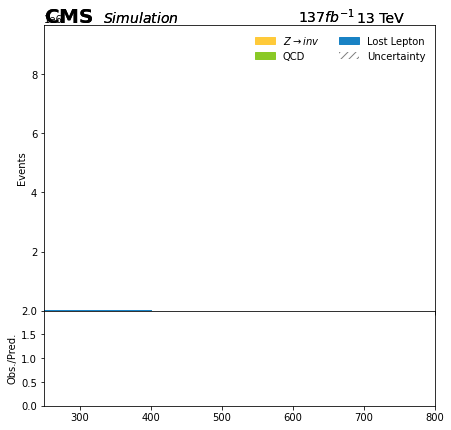

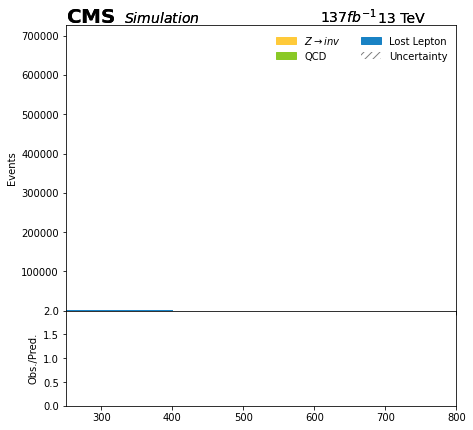

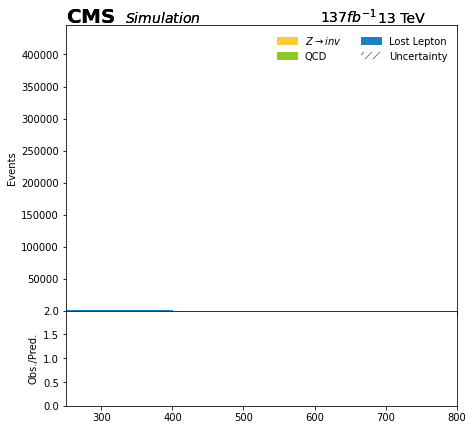

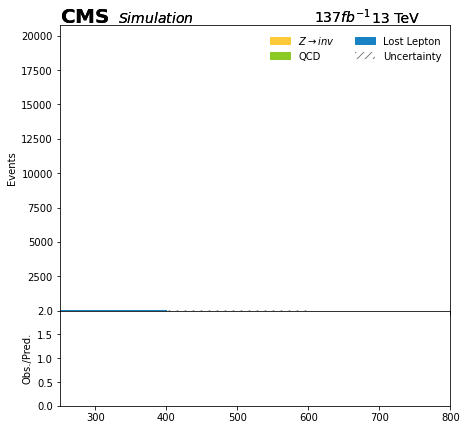

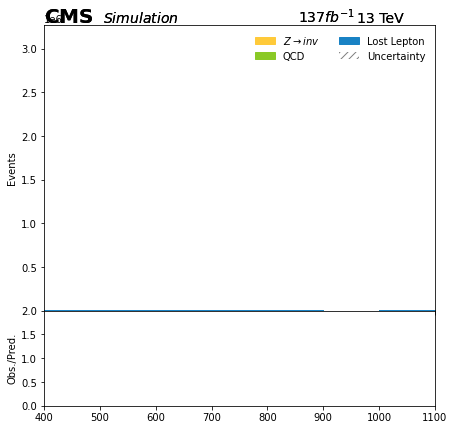

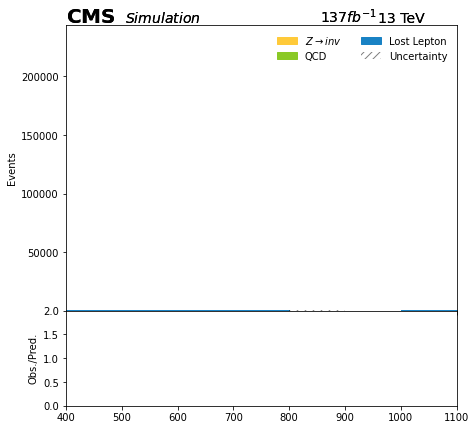

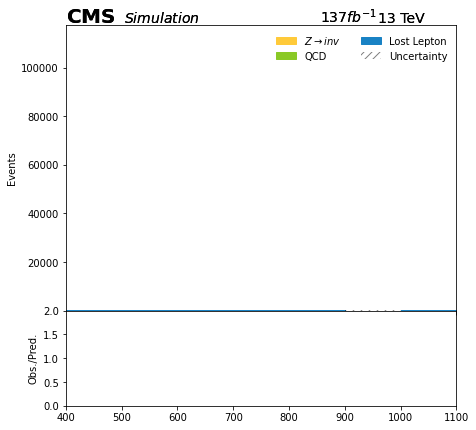

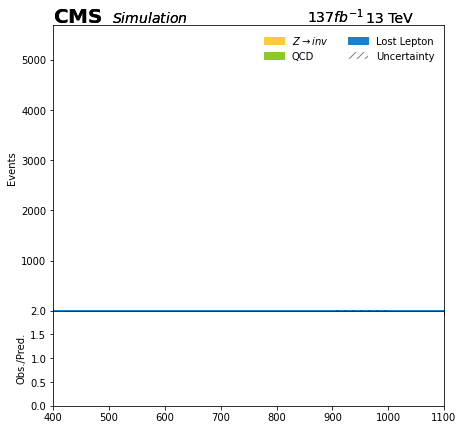

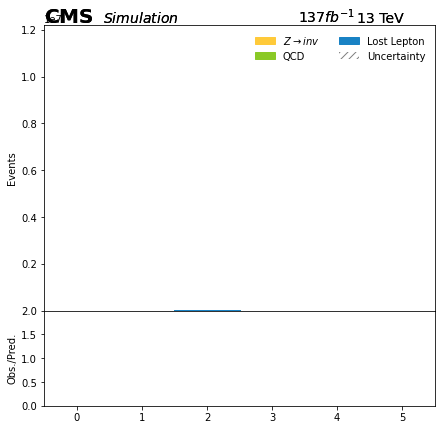

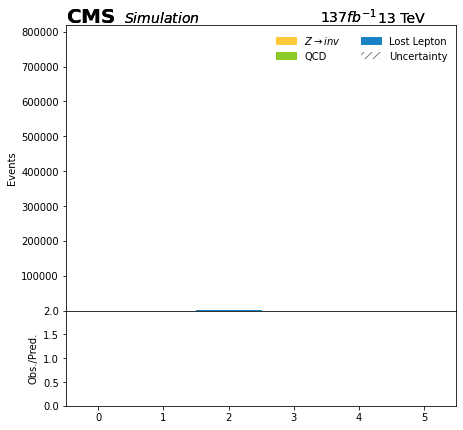

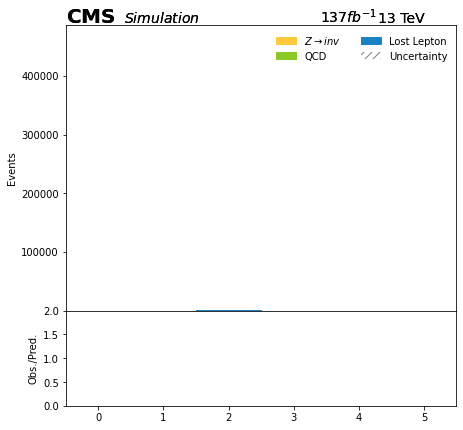

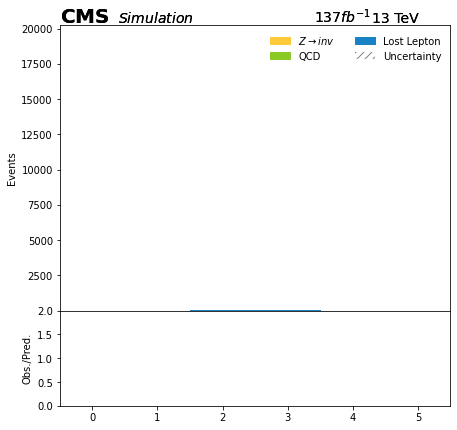

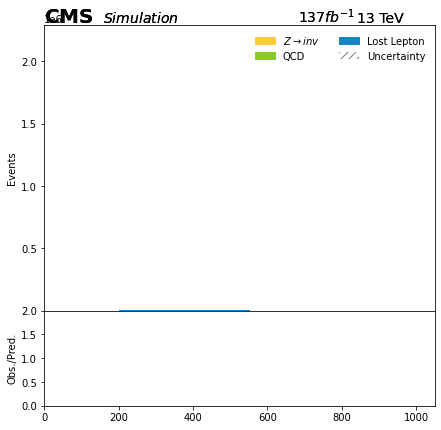

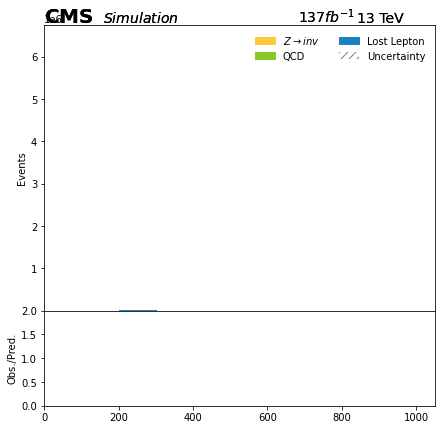

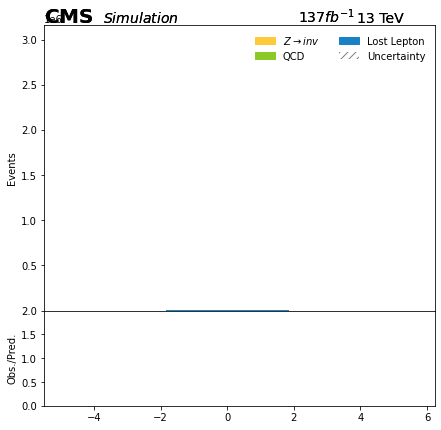

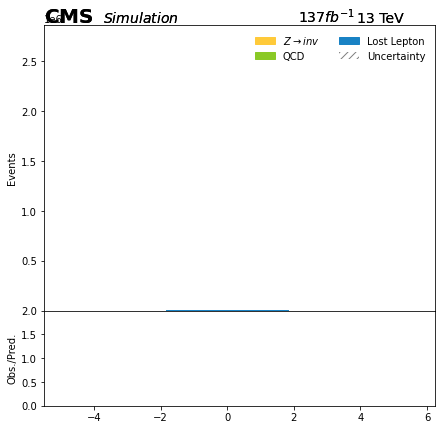

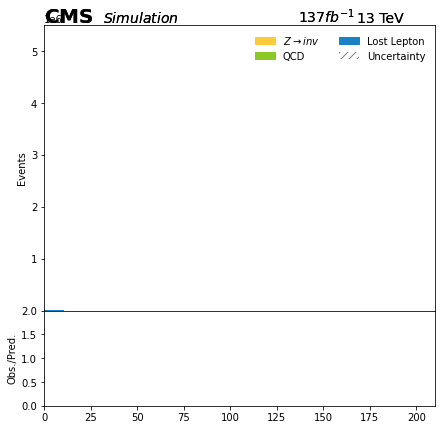

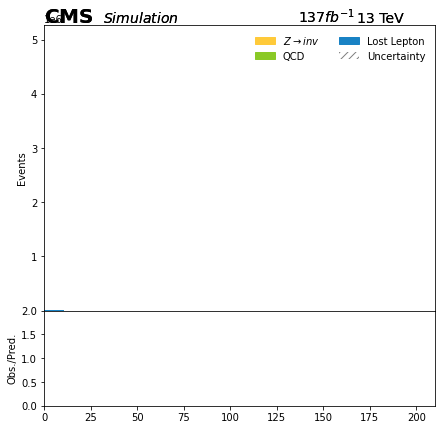

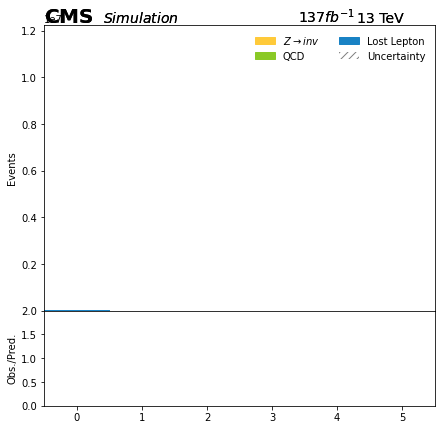

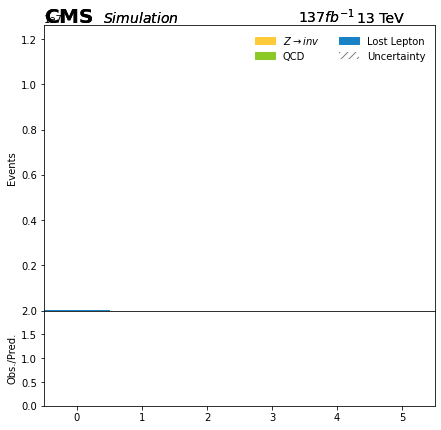

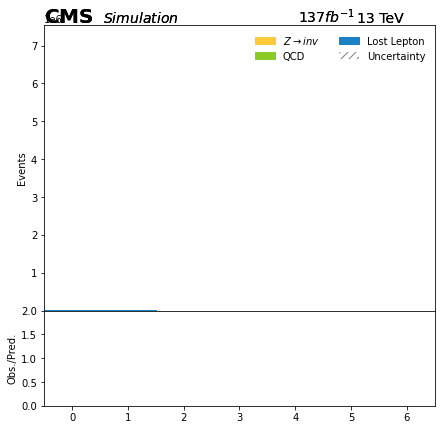

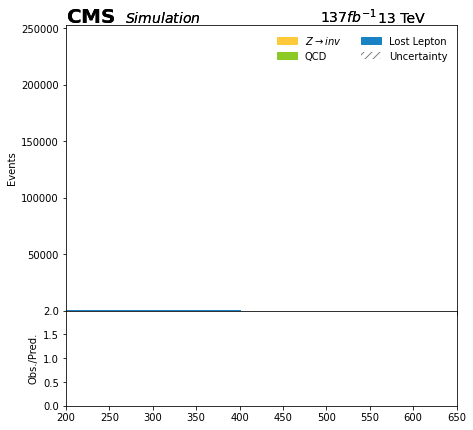

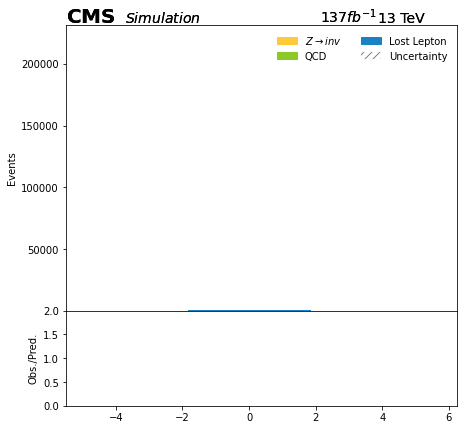

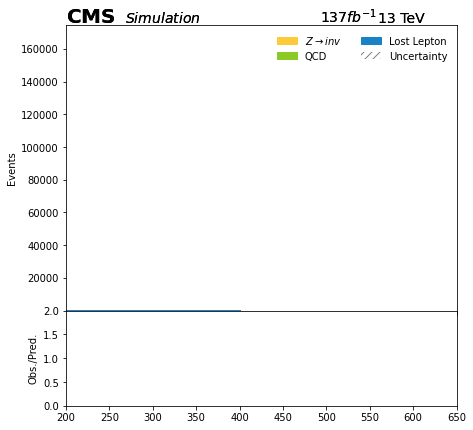

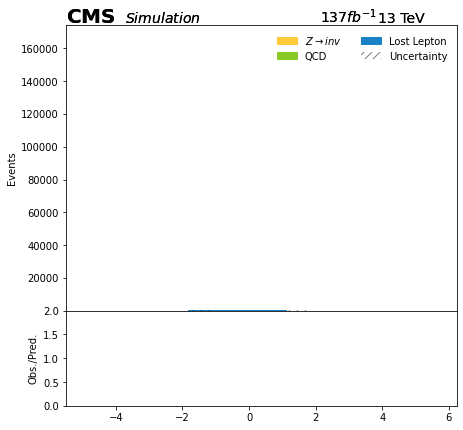

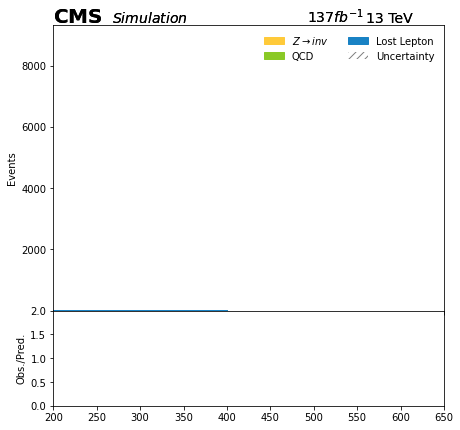

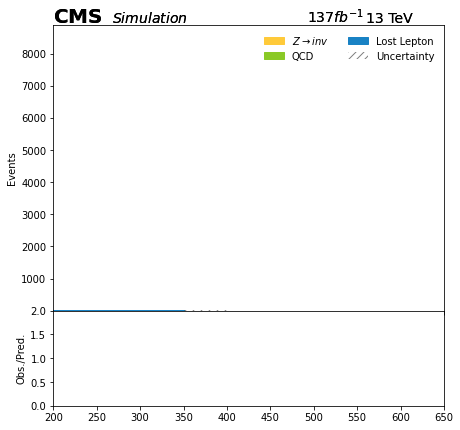

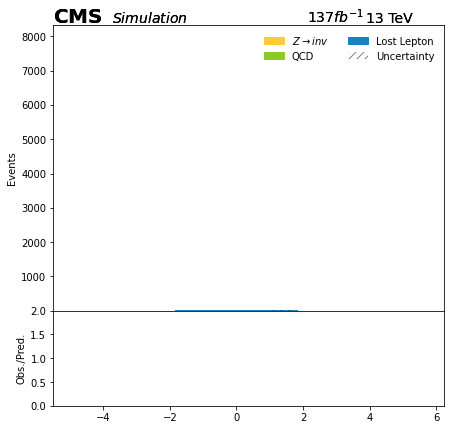

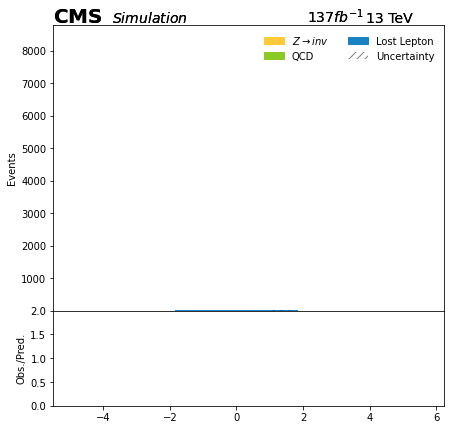

In [23]:
# Make some of the plots

plotDir = '/home/users/ksalyer/public_html/dump/WH_had/'
finalizePlotDir(plotDir)

for plot in histos:

    name = plot[0]
    binName = plot[1]
    print(name)
    histogram = output[name]

    axis = bins[binName]['axis']
    histogram = histogram.rebin(axis, bins[binName]['bins'])

    y_max = histogram.sum("dataset").values(overflow='all')[()].max()
    y_over = histogram.sum("dataset").values(overflow='all')[()][-1]

    import re
    bkganddata = re.compile('(?!mC750_l1)')
    bkgandsig = re.compile('(?!Data)')
    
    background = histogram[bkganddata][bkgandsig]
    signal = histogram['mC750_l1']
    data = histogram['Data']

    #fig, ax = plt.subplots(1,1,figsize=(7,7))
    fig, (ax, rax) = plt.subplots(nrows=2,ncols=1, figsize=(7,7),
        gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
    
    # get axes
    #hist.plot1d(background, overlay="dataset", ax=ax, stack=True, overflow=bins[binName]['overflow'], clear=False, fill_opts=fillopts2, error_opts=error_opts)#, order=['TTJets', 'ST', 'ttW', 'WW', 'ZNuNu', 'QCD', 'WJets']) #error_opts??
    hist.plot1d(background, overlay="dataset", ax=ax, stack=True, overflow=bins[binName]['overflow'], clear=False, fill_opts=fill_opts, error_opts=error_opts)#, order=['QCD', 'ZNuNu', 'WW', 'ttW', 'ST', 'WJets', 'TTJets']) #error_opts??
    #hist.plot1d(signal, overlay="dataset", ax=ax, stack=False, overflow=bins[binName]['overflow'], line_opts=lineopts, clear=False)
    #hist.plot1d(data, overlay="dataset", ax=ax, stack=False, overflow=bins[binName]['overflow'], error_opts=data_err_opts_rat, clear=False)

    #hist.plotratio(num=data.sum('dataset'), denom=background.sum('dataset'), ax=rax,
    #               error_opts = data_err_opts_rat, denom_fill_opts={}, guide_opts={}, 
    #               unc='num', overflow = 'over')

    for l in ['log', 'linear']:
        saveFig(fig, ax, rax, plotDir, name, scale=l, shape=False, y_max=y_max)
